# Music generation

In [1]:
import numpy as np
import pandas as pd
import glob
import pathlib
import collections
import datetime
# import fluidsynth # corrupt
import pretty_midi
import seaborn as sns
import tensorflow as tf
from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

C:\Python310\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


## Process the MIDI files

In [12]:
seed = 420
tf.random.set_seed(seed)
np.random.seed(seed)
# Sampling rate for audio playback
_SAMPLING_RATE = 16000
data_dir = pathlib.Path('../data')
filenames = glob.glob(str('**/*/*.mid*'),root_dir=data_dir)
print('Number of all MIDI files:', len(filenames)) # 1646, 18243, 18525

Number of all MIDI files: 1646


In [3]:
# for i in range(12,132,1):
#     print(f'{i} -- {pretty_midi.note_number_to_name(i)}')

In [20]:
# ok  = open('ok.txt', 'wt', encoding="utf-8")
# bad = open('bad.txt', 'wt', encoding="utf-8")
# good= open('good.csv', 'wt', encoding="utf-8")

s=0
for fn in filenames:
    s+=1
    rel_path = str(data_dir)+'\\'+fn
    # print(f'{s:6d}, {fn}')
    # try:
        # pm = pretty_midi.PrettyMIDI(rel_path)

    # except:
        # log and delete all the invalid MIDI flies
        # bad.write(f'{s:6d}, {fn}\n')
        # pathlib.Path(rel_path).unlink(missing_ok=True)
        # continue

    # if len(pm.instruments)==1:
    #     s+=1
        # print(f'good {s:6d}\t{fn}')
    # good.write(f'{s:6d}, {rel_path}\n')
    # else:

        # i=0
        # print(f'ok {s:6d}\t{fn}')
        # ok.write(f'ok {s:6d}, {rel_path}\n')
        # for inst in pm.instruments:
        #     i+=1
        #     ok.write(f'\t{i:2d}. {inst.program:3d}, {pretty_midi.program_to_instrument_name(inst.program)}\n')
print('Number of 1-instrument MIDI files:', s) # 1656 = 374 pop + 1282 maestro

# good.close()
# bad.close()
# ok.close()

faves = (218,220,229,230,269,270,271,326,331,333,334,335,336,342)
for i in faves:
	print(filenames[i])

Number of 1-instrument MIDI files: 1646
clean_midi\Led Zeppelin\Stairway To Heaven.7.mid
clean_midi\Lennon John\Imagine.2.mid
clean_midi\Metallica\(Anesthesia)-Pulling Teeth.1.mid
clean_midi\Metallica\Die, Die My Darling.mid
clean_midi\Queen\Procession.mid
clean_midi\Ray Charles\Georgia.mid
clean_midi\Roberta Flack\Killing Me Softly.mid
clean_midi\Soundgarden\One Minute of Silence.mid
clean_midi\The Beatles\Eight Days A Week.4.mid
clean_midi\The Beatles\I'm Gonna Sit Right Down and Cry (Over You).mid
clean_midi\The Beatles\In My Life.1.mid
clean_midi\The Beatles\In My Life.5.mid
clean_midi\The Beatles\Sgt. Pepper Inner Groove.mid
clean_midi\U2\The Electric Co..1.mid


## Extract notes

Three variables that represent a note are: `pitch`, `step` and `duration`.
The `pitch` is the perceptual quality of the sound as a MIDI note number.
The `step` is the time elapsed from the previous note or start of the track.
The `duration` is how long the note will be playing in seconds and `duration` = note end - start times.
To simplify the sampling process I will extract one-instrument MIDI files to a notes dataframe.

In [18]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    # 1st & only instrument
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    _start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - _start)
        notes['duration'].append(end - start)
        _start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [19]:
def plot_track(notes: pd.DataFrame, name: Optional[str] = None):
    if name:
        title = f'{name}'
    else:
        title = f'The whole enchilada'
    count = len(notes['pitch'])
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color="g", marker="o")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)

clean_midi\Led Zeppelin\Stairway To Heaven.7.mid
clean_midi\Lennon John\Imagine.2.mid
clean_midi\Metallica\(Anesthesia)-Pulling Teeth.1.mid
clean_midi\Metallica\Die, Die My Darling.mid
clean_midi\Queen\Procession.mid
clean_midi\Ray Charles\Georgia.mid
clean_midi\Roberta Flack\Killing Me Softly.mid
clean_midi\Soundgarden\One Minute of Silence.mid
clean_midi\The Beatles\Eight Days A Week.4.mid
clean_midi\The Beatles\I'm Gonna Sit Right Down and Cry (Over You).mid
clean_midi\The Beatles\In My Life.1.mid
clean_midi\The Beatles\In My Life.5.mid
clean_midi\The Beatles\Sgt. Pepper Inner Groove.mid
clean_midi\U2\The Electric Co..1.mid
17229 number of notes parsed from 14 tracks.


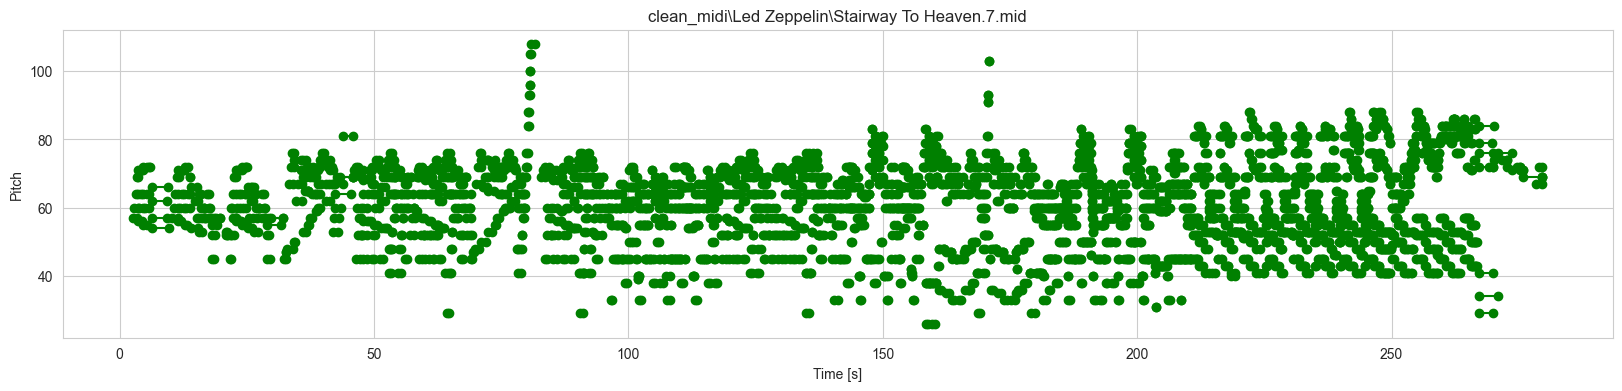

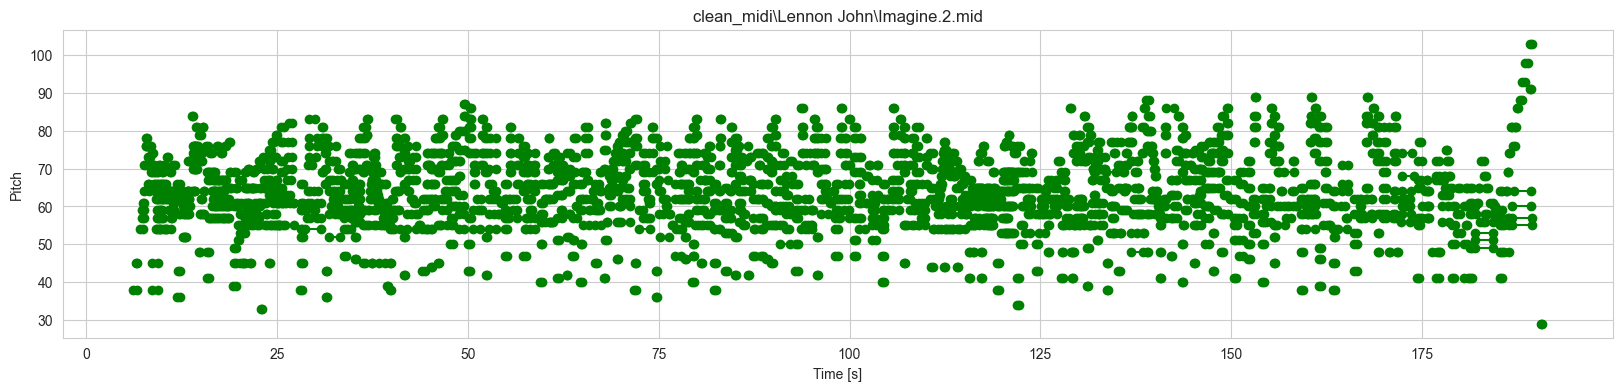

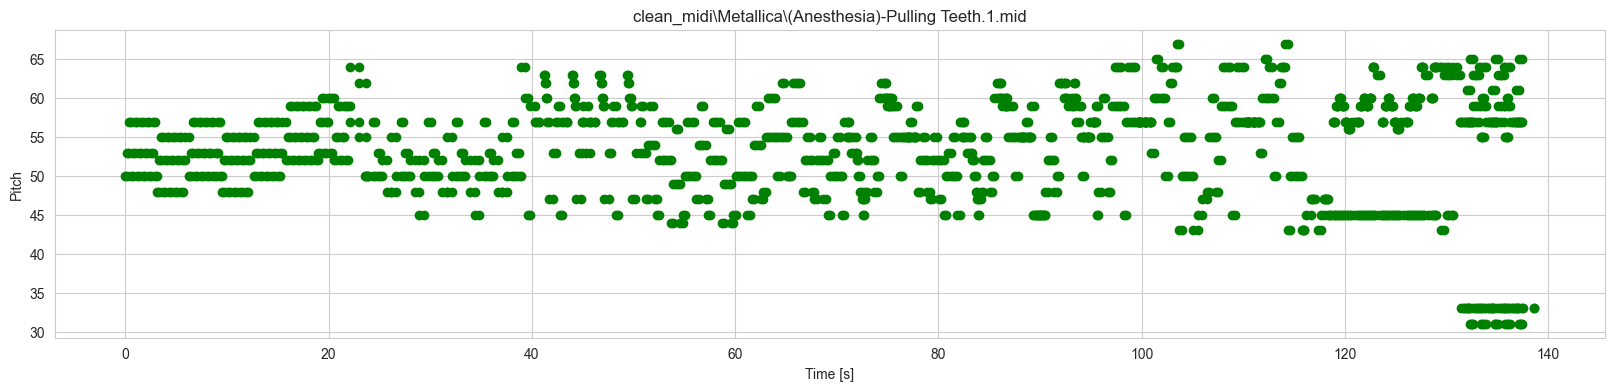

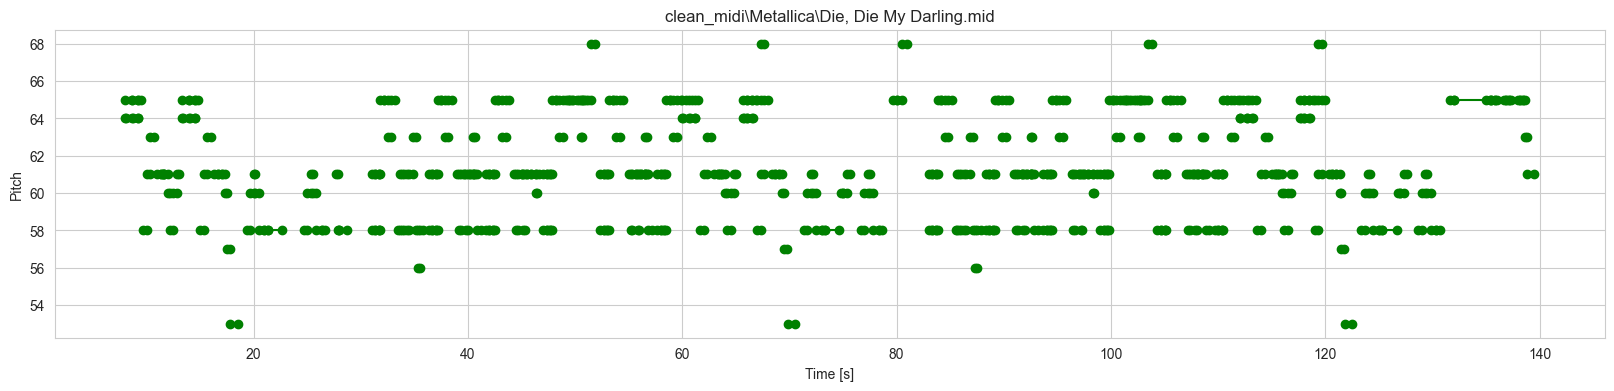

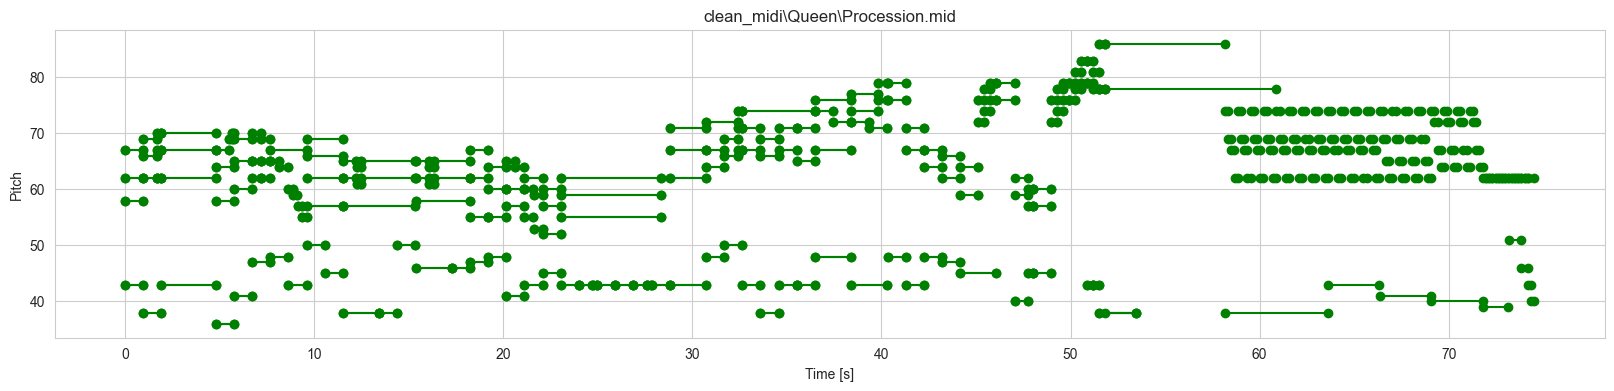

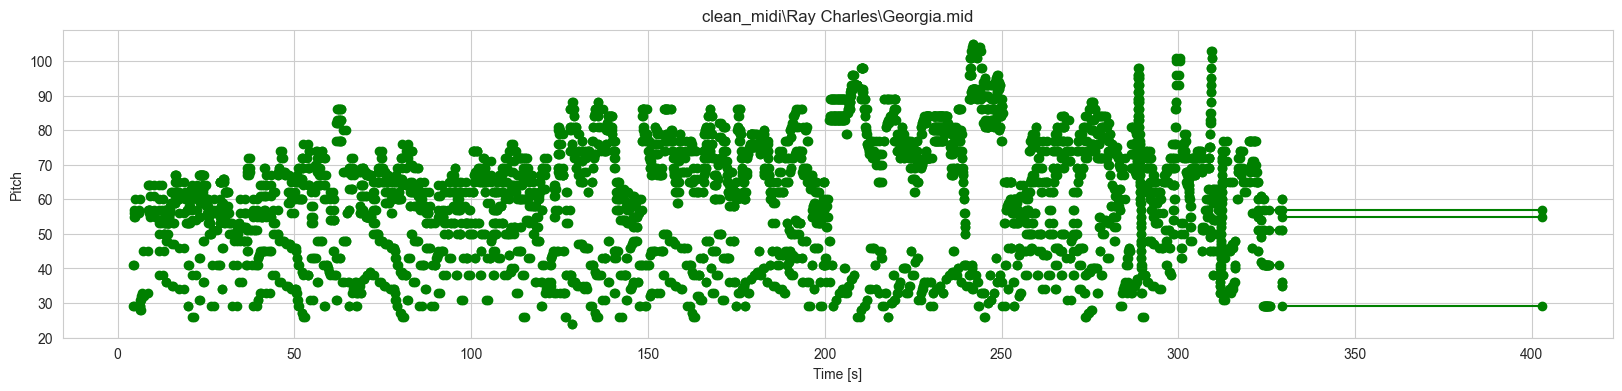

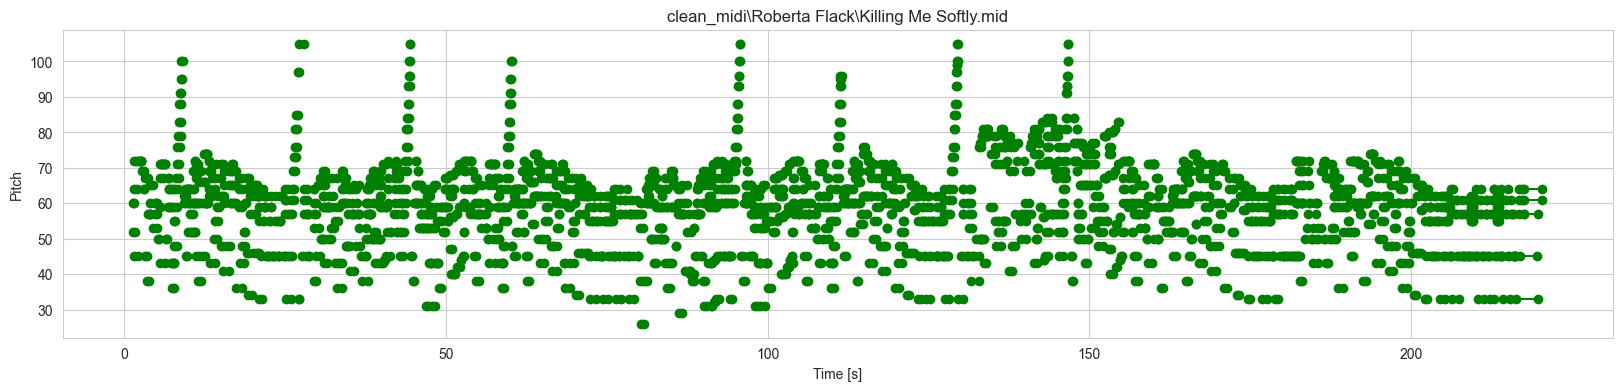

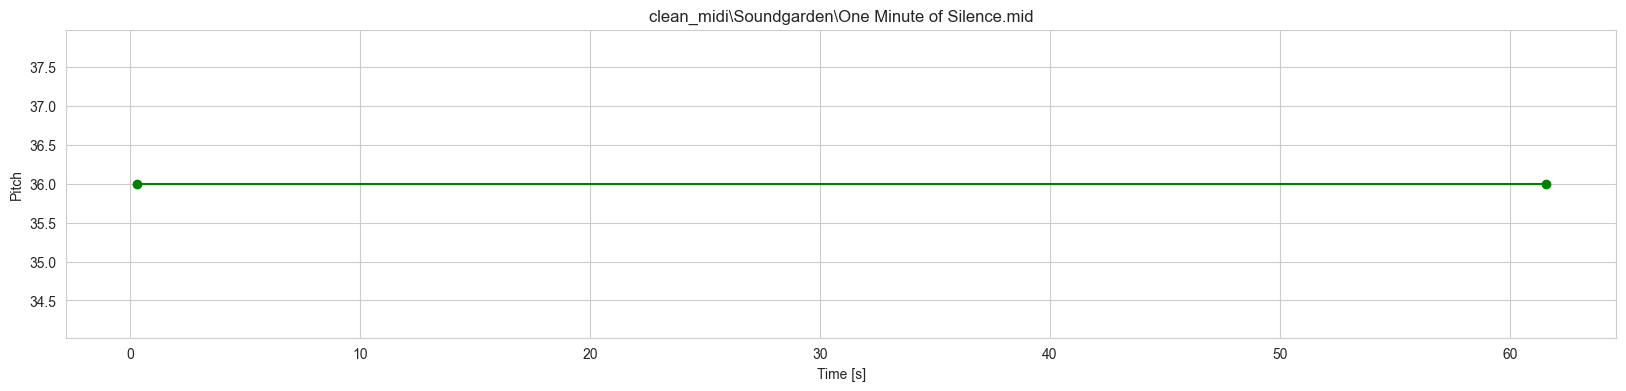

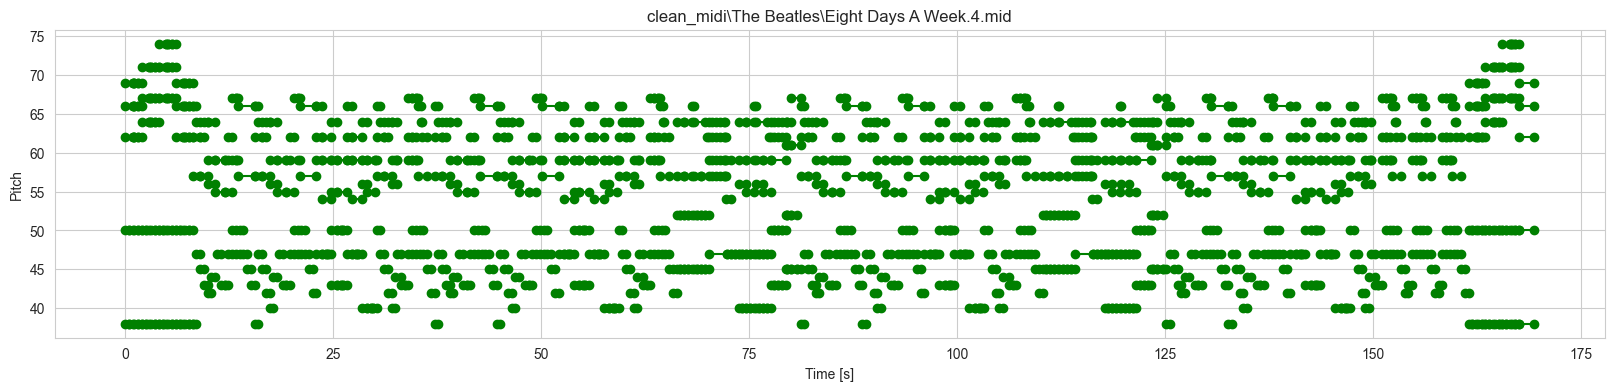

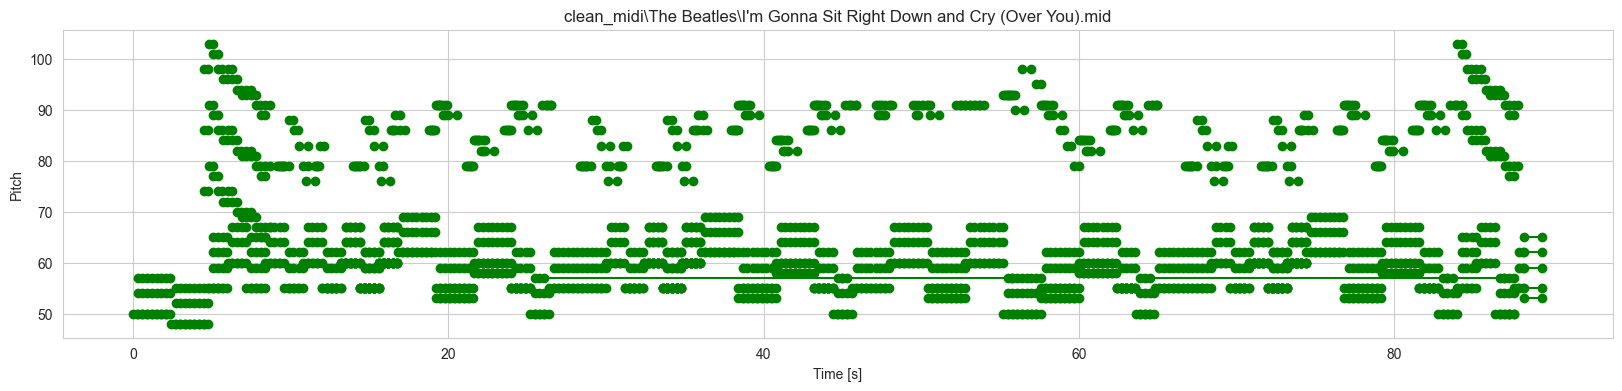

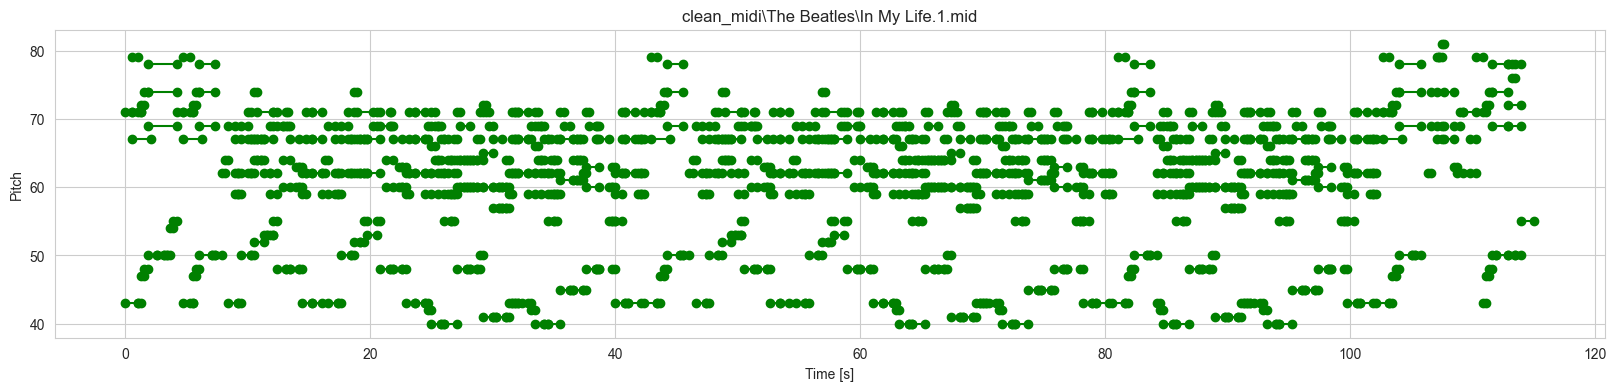

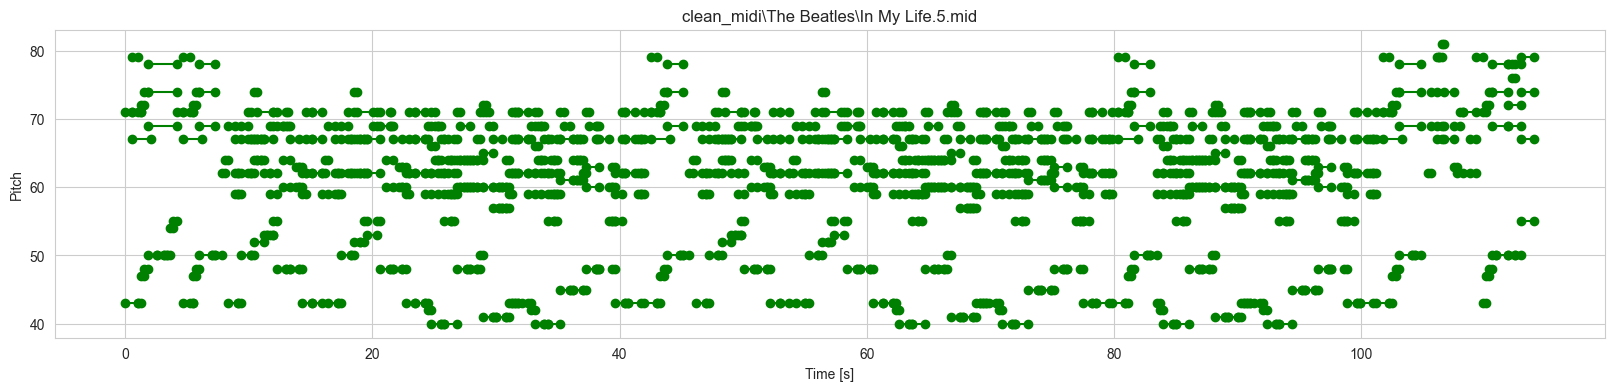

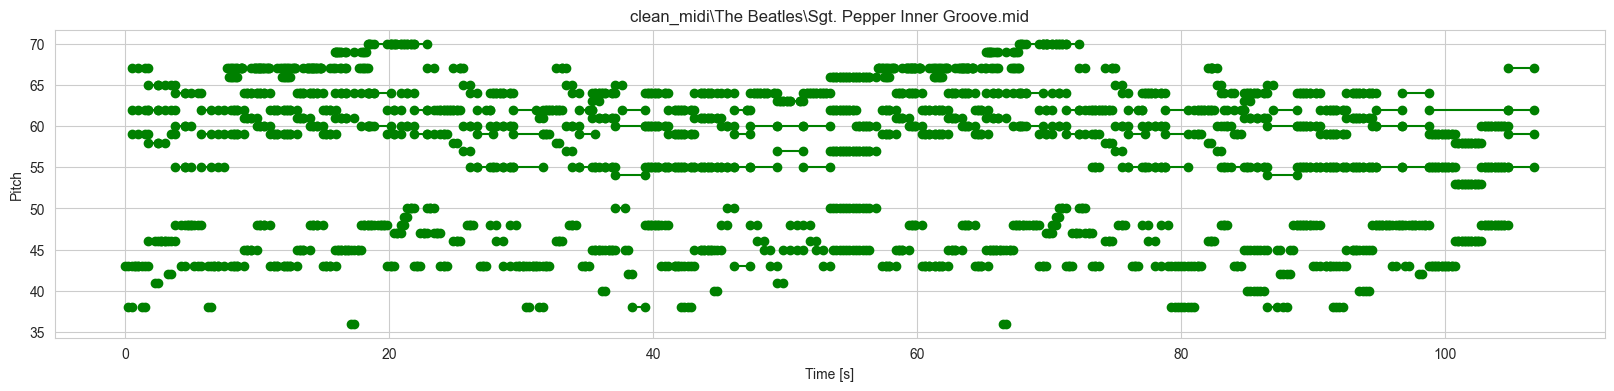

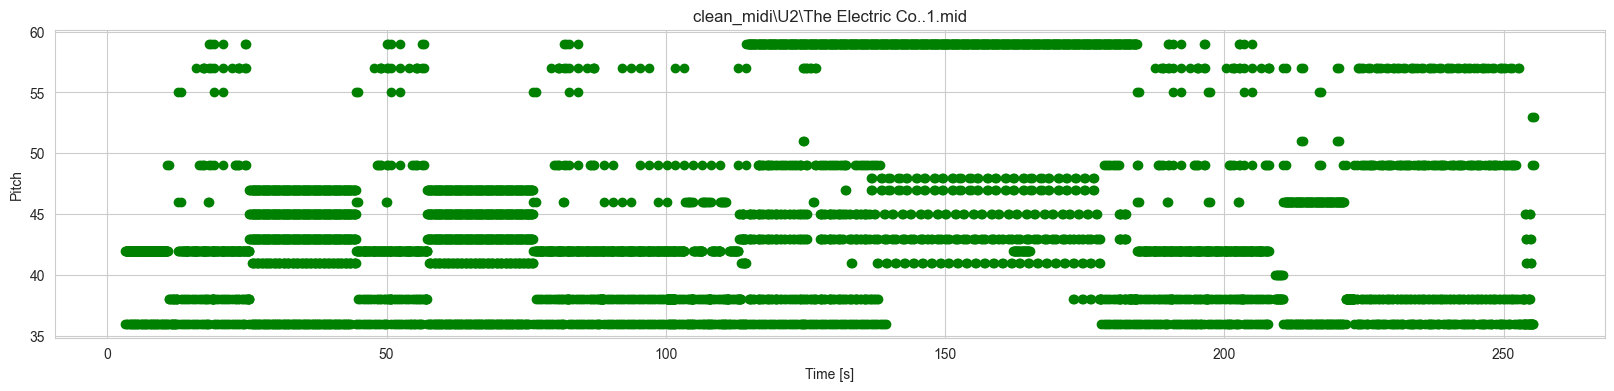

In [21]:
faves = (218,220,229,230,269,270,271,326,331,333,334,335,336,342)
all_notes = []
for i in faves:
    print(filenames[i])
    file = str(data_dir)+'\\'+filenames[i]
    notes = midi_to_notes(file)
    plot_track(notes, filenames[i])
    all_notes.append(notes)
all_notes = pd.concat(all_notes)
print(f'{len(all_notes)} number of notes parsed from {len(faves)} tracks.')

To visualize the musical piece the utility ```plot_track``` function plots the notes ```pitch``` values, ```start``` and ```end``` (as I showed in ```midi_to_notes``` function above the ```step``` and ```duration``` are derived from those) across the length of track(s). The individual tracks plots look informative, however plot of the notes of all 12 tracks, superimposed, looks a bit gibberish.

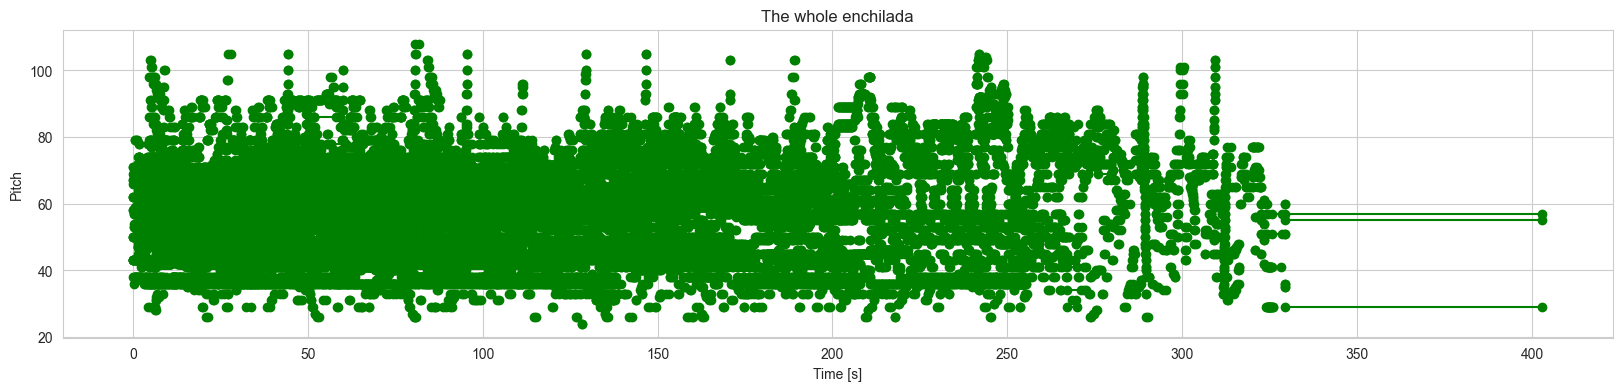

In [23]:
plot_track(all_notes)

Check the distribution of each note variable.

In [24]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
    plt.figure(figsize=[15, 5])
    plt.subplot(1, 3, 1)
    sns.histplot(notes, x="pitch", bins=20)

    plt.subplot(1, 3, 2)
    max_step = np.percentile(notes['step'], 100 - drop_percentile)
    sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

    plt.subplot(1, 3, 3)
    max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
    sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

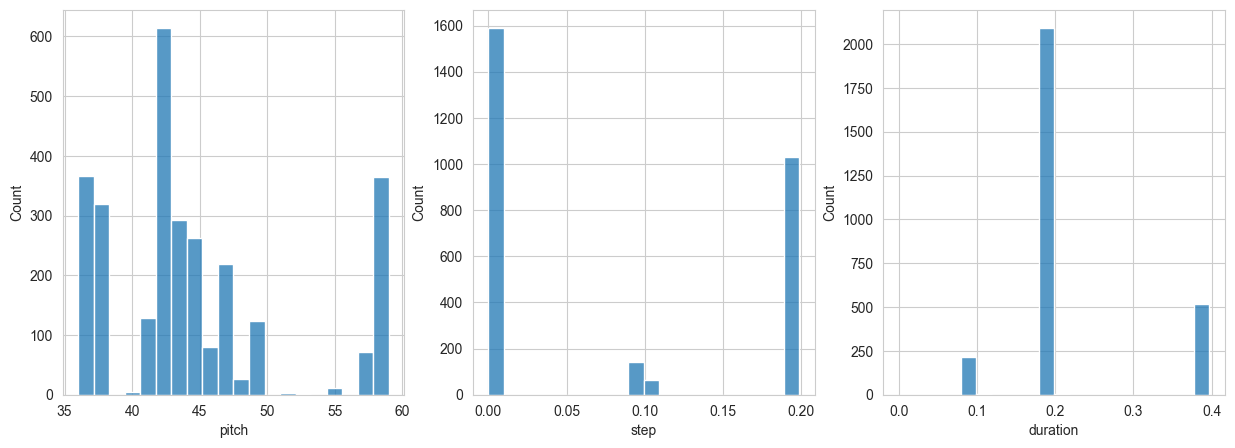

In [25]:
plot_distributions(notes)

## Create a MIDI file with different instruments

Let's generate a MIDI file by changing the instrument, still a 1-imstrument MIDI though.

In [26]:
def notes_to_midi(
    notes: pd.DataFrame,
    out_file: str,
    instrument_name: str,
    velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program(instrument_name))

    _start = 0
    for i, note in notes.iterrows():
        start = float(_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(note['pitch']),
            start=start,
            end=end,
        )
        instrument.notes.append(note)
        _start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

In [27]:
# _instruments=['Bright Acoustic Piano','Electric Guitar (jazz)','Electric Bass (finger)','Cello','Sitar','Bagpipe','Voice Oohs']
# for i in _instruments:
#     fn = f'{data_dir}\\{i}\\{filenames[8426]}' # Imagine
#     # touch data_dir\instrument\path\to\song.midi
#     pathlib.Path(fn).mkdir()
#     pathlib.Path(fn).touch(exist_ok=True)
#     pm = notes_to_midi(notes, out_file=fn, instrument_name=i)

## Create the training dataset

A training `tf.data.Dataset` is created from the parsed MIDI files notes. Let's start with the 12 files, and see how it goes.

In [28]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [29]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

Let's train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and the next note as the label. This way, the model will be trained to predict the next note in a sequence. A useful diagram describing this process (and more details) are given in [Text classification with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

Let's use the handy [tf.data.Dataset.window](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) function with size `seq_length` to create the features and labels in this format.

In [30]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
    """Returns TF Dataset of sequence and label examples."""
    seq_length = seq_length+1

    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True)

    # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)
  
    # Normalize note pitch
    def scale_pitch(x):
        x = x/[vocab_size,1.0,1.0]
        return x

    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

        return scale_pitch(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Set the sequence length for each example. Experiment with different lengths (e.g. 50, 100, 150) to see which one works best for the data, or use [hyperparameter tuning](https://www.tensorflow.org/tutorials/keras/keras_tuner). The size of the vocabulary (`vocab_size`) is set to 128 representing all the pitches supported by `pretty_midi`.

In [31]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

The shape of the dataset is ```(100,1)```, meaning that the model will take 100 notes as input, and learn to predict the following note as output.

In [32]:
for seq, target in seq_ds.take(1):
    print('sequence shape:', seq.shape)
    print('sequence elements (first 10):', seq[0: 10])
    print()
    print(f'target pitch: {target["pitch"]:1.0f}, step: {target["step"]:1.4f}, duration: {target["duration"]:1.4f}')

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.4453125  0.         0.825     ]
 [0.46875    0.25833333 0.65      ]
 [0.5        0.2375     0.4125    ]
 [0.5390625  0.225      0.19166667]
 [0.5546875  0.24166667 0.54166667]
 [0.4375     0.00416667 0.85      ]
 [0.46875    0.27916667 0.63333333]
 [0.5        0.27916667 0.40833333]
 [0.5546875  0.24583333 0.23333333]
 [0.5625     0.2875     0.62916667]], shape=(10, 3), dtype=float64)

target pitch: 64, step: 0.3250, duration: 0.4625


Batch the examples, and configure the dataset for performance.

In [33]:
batch_size = 64
n_notes = len(notes)
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [34]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create and train the model

The model will have three outputs, one for each note variable. For `step` and `duration`, I will use a custom loss function based on MSE that encourages the model to output non-negative values.

In [35]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [36]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': 	  tf.keras.layers.Dense(128, name='pitch')(x),
  'step': 	  tf.keras.layers.Dense(1,   name='step')(x),
  'duration': tf.keras.layers.Dense(1,   name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch':    tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      'step': 	  mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

Testing the `model.evaluate` function, you can see that the `pitch` loss is significantly greater than the `step` and `duration` losses. 
Note that `loss` is the total loss computed by summing all the other losses and is currently dominated by the `pitch` loss.

In [37]:
losses = model.evaluate(train_ds, return_dict=True)
losses

# InvalidArgumentError: Graph execution error
# No OpKernel was registered to support Op 'CudnnRNN' used by {{node CudnnRNN}} with these attrs: [seed=0, dropout=0, T=DT_FLOAT, input_mode="linear_input", direction="unidirectional", rnn_mode="lstm", seed2=0, is_training=true]
# Registered devices: [CPU, GPU]
# Registered kernels:
#   <no registered kernels>
#
# 	 [[CudnnRNN]]
# 	 [[model/lstm/PartitionedCall]] [Op:__inference_test_function_1969]

InvalidArgumentError: Graph execution error:

No OpKernel was registered to support Op 'CudnnRNN' used by {{node CudnnRNN}} with these attrs: [seed=0, dropout=0, T=DT_FLOAT, input_mode="linear_input", direction="unidirectional", rnn_mode="lstm", seed2=0, is_training=true]
Registered devices: [CPU, GPU]
Registered kernels:
  <no registered kernels>

	 [[CudnnRNN]]
	 [[model/lstm/PartitionedCall]] [Op:__inference_test_function_1969]

One way balance this is to use the `loss_weights` argument to compile:

In [35]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

The `loss` then becomes the weighted sum of the individual losses.

In [36]:
model.evaluate(train_ds, return_dict=True)

InvalidArgumentError: Graph execution error:

No OpKernel was registered to support Op 'CudnnRNN' used by {{node CudnnRNN}} with these attrs: [seed=0, dropout=0, T=DT_FLOAT, input_mode="linear_input", direction="unidirectional", rnn_mode="lstm", seed2=0, is_training=true]
Registered devices: [CPU, GPU]
Registered kernels:
  <no registered kernels>

	 [[CudnnRNN]]
	 [[model/lstm/PartitionedCall]] [Op:__inference_test_function_3342]

Train the model.

In [37]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [38]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50


InvalidArgumentError: Graph execution error:

No OpKernel was registered to support Op 'CudnnRNN' used by {{node CudnnRNN}} with these attrs: [seed=0, dropout=0, T=DT_FLOAT, input_mode="linear_input", direction="unidirectional", rnn_mode="lstm", seed2=0, is_training=true]
Registered devices: [CPU, GPU]
Registered kernels:
  <no registered kernels>

	 [[CudnnRNN]]
	 [[model/lstm/PartitionedCall]] [Op:__inference_train_function_5880]

In [39]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

NameError: name 'history' is not defined

## Generate notes

To use the model to generate notes, you will first need to provide a starting sequence of notes. The function below generates one note from a sequence of notes. 

For note pitch, it draws a sample from the softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability.
Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

The `temperature` parameter can be used to control the randomness of notes generated. You can find more details on temperature in [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

In [40]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Now generate some notes. You can play around with temperature and the starting sequence in `next_notes` and see what happens.

In [41]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

InvalidArgumentError: Graph execution error:

No OpKernel was registered to support Op 'CudnnRNN' used by {{node CudnnRNN}} with these attrs: [seed=0, dropout=0, T=DT_FLOAT, input_mode="linear_input", direction="unidirectional", rnn_mode="lstm", seed2=0, is_training=true]
Registered devices: [CPU, GPU]
Registered kernels:
  <no registered kernels>

	 [[CudnnRNN]]
	 [[model/lstm/PartitionedCall]] [Op:__inference_predict_function_6408]

In [42]:
generated_notes.head(10)

AttributeError: 'list' object has no attribute 'head'

In [43]:
out_file = 'output.mid'
out_pm = notes_to_midi(generated_notes, out_file=out_file, instrument_name=instrument_name)
# display_audio(out_pm)

NameError: name 'notes_to_midi' is not defined

Visualize the generated notes.

In [44]:
plot_track(generated_notes)

TypeError: list indices must be integers or slices, not str

Check the distributions of `pitch`, `step` and `duration`.

ValueError: Could not interpret value `pitch` for parameter `x`

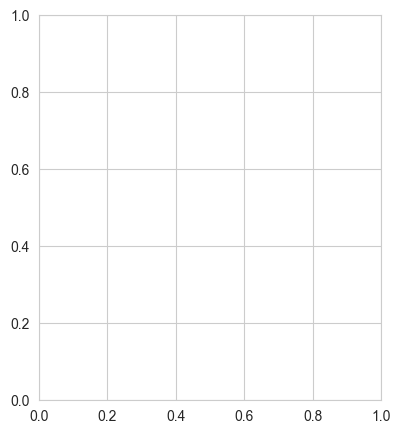

In [45]:
plot_distributions(generated_notes)

In the above plots, you will notice the change in distribution of the note variables.
Since there is a feedback loop between the model's outputs and inputs, the model tends to generate similar sequences of outputs to reduce the loss. 
This is particularly relevant for `step` and `duration`, which uses the MSE loss.
For `pitch`, you can increase the randomness by increasing the `temperature` in `predict_next_note`.


## Next steps

This tutorial demonstrated the mechanics of using an RNN to generate sequences of notes from a dataset of MIDI files. To learn more, you can visit the closely related [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial, which contains additional diagrams and explanations. 

One of the alternatives to using RNNs for music generation is using GANs. Rather than generating audio, a GAN-based approach can generate an entire sequence in parallel. The Magenta team has done impressive work on this approach with [GANSynth](https://magenta.tensorflow.org/gansynth). You can also find many wonderful music and art projects and open-source code on [Magenta project website](https://magenta.tensorflow.org/).